# Sentiment Analysis with BERT



In [ ]:
#@title Python, CUDA environment setup & config

!nvidia-smi
!pip install -q -U watermark
!pip install -qq transformers
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from google.colab import drive

import pandas as pd
import pprint
pp = pprint.PrettyPrinter()


drive.mount('/drive')

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


#@title Torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

Tue Dec  6 07:08:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    29W /  70W |   1598MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device


device(type='cuda', index=0)

In [ ]:
nav_path = '/drive/MyDrive/ubuntu/ptt_advertorial/raw_data/makeup_dataset_4_limit1200'
os.listdir (nav_path)

['all.xlsx', 'train.csv', 'test.csv', 'balance.csv', 'desc.txt']

In [ ]:
# @title Config
source_file = "/drive/MyDrive/ubuntu/ptt_advertorial/raw_data/makeup_dataset_4_limit1200/test.csv"
model_path = '/drive/MyDrive/ubuntu/ptt_advertorial/model/bert_1028_1to1200_2/best_model_state.bin'

PRE_TRAINED_MODEL_NAME = 'hfl/chinese-roberta-wwm-ext'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
MAX_LEN = 140
BATCH_SIZE = 16


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


neutral     663
positive    593
negative    538
Name: senta_product, dtype: int64


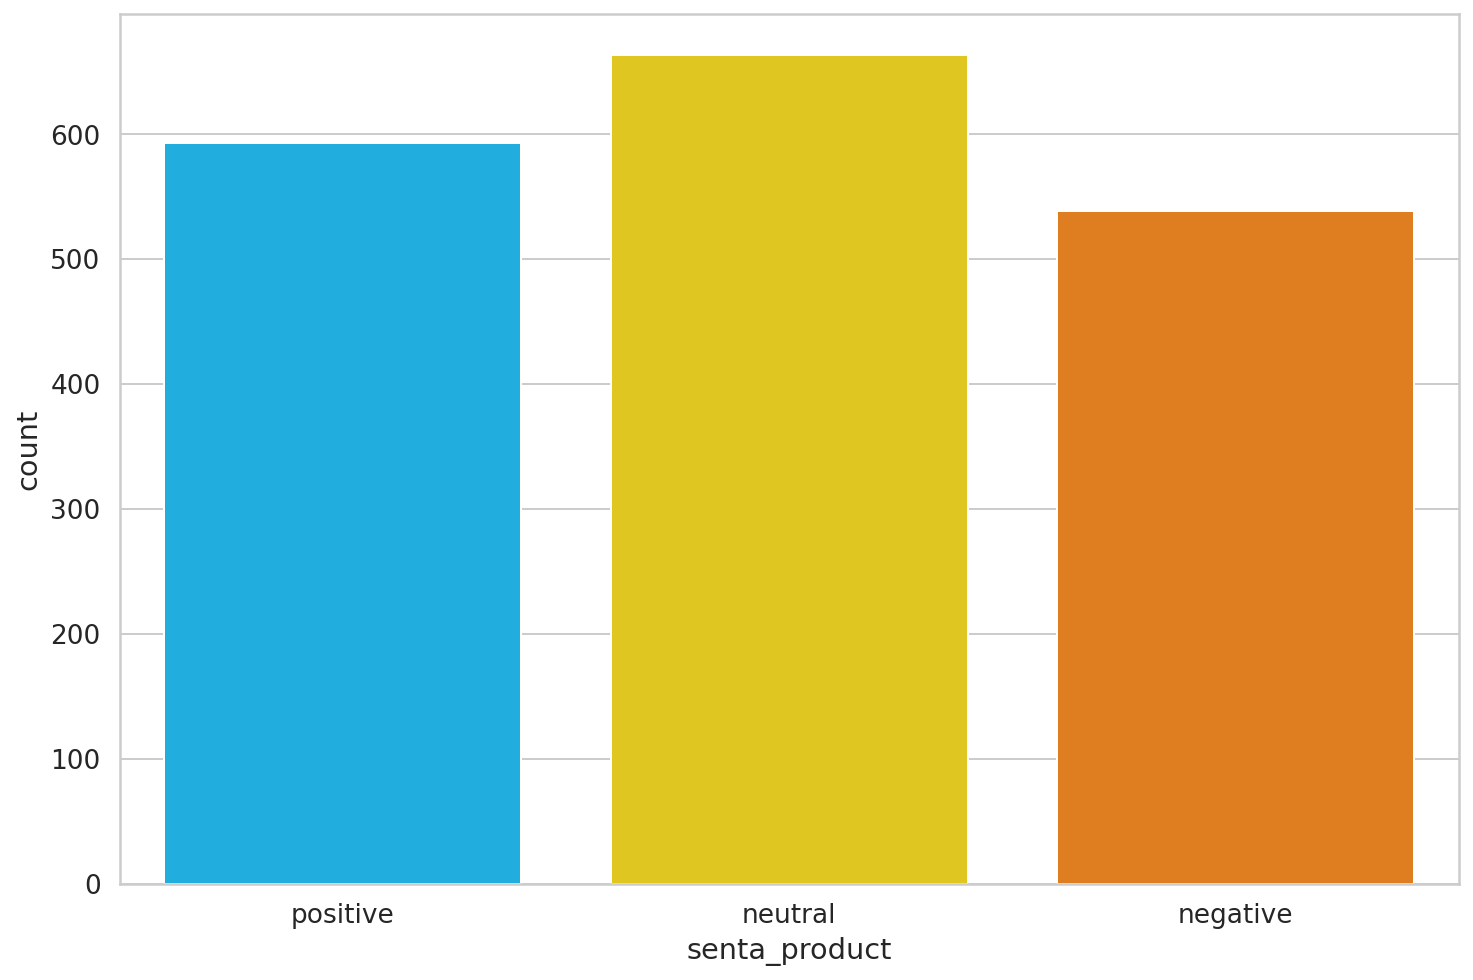

In [ ]:
# @title Read data
df = pd.read_csv(source_file,sep='\t')

# print(df.info())
#use senta_article as default senta_product value
def set_senta_article_as_default(row):
    if pd.isna(row['senta_product']):
      return row['senta_article']
    else:
      return row['senta_product']
    
class_names = ['negative', 'neutral', 'positive']
class_map = {'negative':0,'neutral':1,'positive':2}

#senta_product 化妝品的情緒反應 ex.口紅很好用
#senta_article  化妝品文章的情緒反應 ex. 這個文章很實用
# 由於化妝品的情緒反應 缺失 所以以化妝品文章的情緒反應作為預設值
df['senta_product'] = df.apply(set_senta_article_as_default,axis='columns')
df['senta_product'] = df['senta_product'].astype(str)
df['senta_article'] = df['senta_article'].astype(str)
df['comment'] = df['comment'].astype(str)

# df['senta_product'] = df['senta_product'].astype(str)
# df['senta_article'] = df['senta_article'].astype(str)




sns.countplot(df.senta_product)
plt.xlabel('senta_product');
print(df['senta_product'].value_counts())
# transform senta_article to senta_product aviod tensor type cannot be string issue 
df['senta_article'] = df['senta_article'].map(class_map)
df['senta_product'] = df['senta_product'].map(class_map)
df_test = df



In [ ]:
# #@title Token cont 
# token_lens = []

# for txt in df.comment	:
#   tokens = tokenizer.encode(txt, max_length=512)
#   token_lens.append(len(tokens))
# sns.distplot(token_lens)
# plt.xlim([0, 256]);
# plt.xlabel('Token count');

In [ ]:
#@title Main


class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }


def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.comment.to_numpy(),
    targets=df.senta_product.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )


class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask, return_dict=False
      
    )
    output = self.drop(pooled_output)
    return self.out(output)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

loss_fn = nn.CrossEntropyLoss().to(device)
model = SentimentClassifier(3)
# model = model.to(device)

# state_dict_path = '/home/arden/Documents/gdrive/ptt_advertorial/model/bert_1028_1to1200_2/best_model_state.bin'
model.load_state_dict(torch.load(model_path))
model = model.to(device)


test_data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)


test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()


Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. 

0.8556298773690078

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(   input_ids=input_ids,attention_mask=attention_mask )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest se

In [ ]:




# for comment,pred,real in zip(y_review_texts, y_pred,y_test):
#     print(comment,class_names[pred],class_names[real])


acc_count = 0
for pred,ans in zip( y_pred,y_test):
    if pred  == ans:
        acc_count+=1
    
print('ACC:',int(acc_count)/int(len(y_test)))



ACC: 0.8556298773690078


In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.76      0.87      0.81       538
     neutral       0.91      0.86      0.88       663
    positive       0.89      0.84      0.87       593

    accuracy                           0.86      1794
   macro avg       0.86      0.86      0.85      1794
weighted avg       0.86      0.86      0.86      1794


是男生嗎

True sentiment: neutral


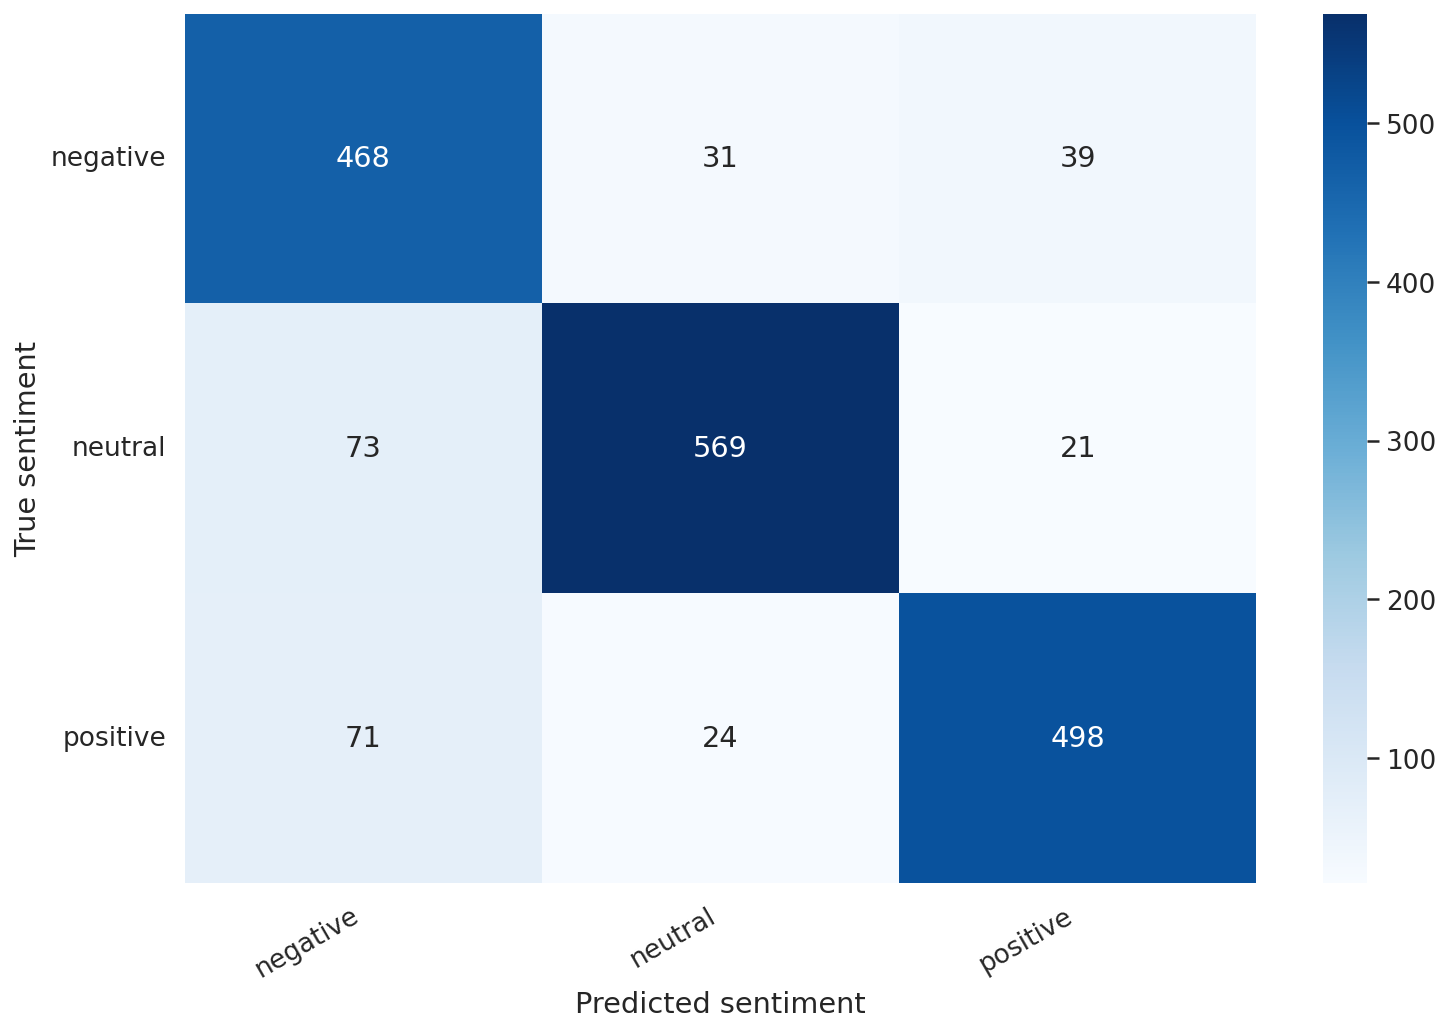

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
pred_df

print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')


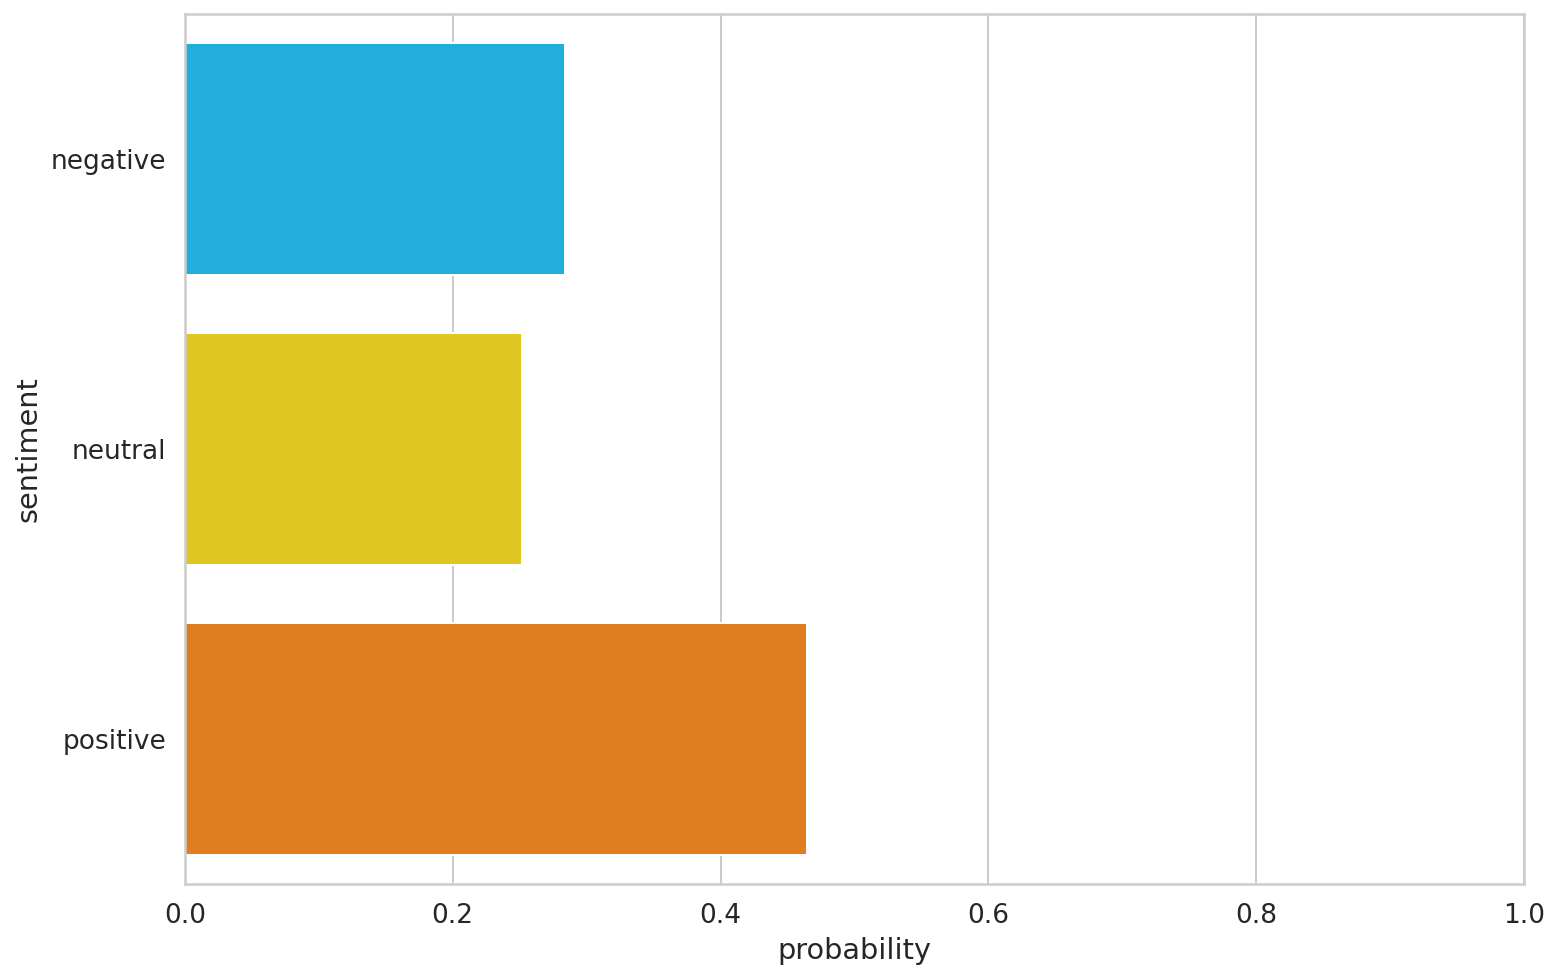

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
review_text = "周慶要大囤貨 : D"
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Review text: 周慶要大囤貨 : D
Sentiment  : positive


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
